In [110]:
print('The "Liquidity" just started running')

The "Liquidity" just started running


Выбор условий выполнения скрипта:

In [111]:
Print_to_excel = True # Создать excel-файл с расчетами? True/False
Print_qualuty_check = False # Вынести QC в отдельный excel-файл? True/False
Send_mail = True # Создать и отправить письмо с расчетами и графиком? True/False
Send_QC_mail = False # Создать и отправить письмо для QC? True/False
mail_to = 'TarakanovMIu@aimmngt.com' # Получатель письма

Необходимые импорты:

In [112]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.drawing.image import Image
import win32com.client as win32
import os

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns

Cash:

In [113]:
query = """
SELECT "holding", SUM("balanceUsd") AS "cash", "reportDate"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "accountStatus" = 'active' AND "bankCountryCode" = 'RU' 
AND "reportDate" >= trunc(sysdate - interval '3' month)
GROUP BY "holding", "reportDate"
ORDER BY "reportDate"
"""

data_cash = export_from_RISKCUSTOM(query)
data_cash['merge_col'] = data_cash[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_cash = data_cash.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_cash.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,cash,reportDate,merge_col
120,EUROCHEM,3.882313e+07,2024-04-18,EUROCHEM_2024-04-18 00:00:00
121,SUEK,3.815390e+07,2024-04-18,SUEK_2024-04-18 00:00:00
122,EUROCHEM,6.743371e+07,2024-04-19,EUROCHEM_2024-04-19 00:00:00
123,SUEK,3.772097e+07,2024-04-19,SUEK_2024-04-19 00:00:00
124,EUROCHEM,7.481899e+07,2024-04-22,EUROCHEM_2024-04-22 00:00:00
125,SUEK,4.209862e+07,2024-04-22,SUEK_2024-04-22 00:00:00


In [114]:
query = """
SELECT "companyCode" AS "holding", SUM("bookValuePositionCurrency") AS "pre_overdraft", "reportDate"
FROM "RISKACCESS"."sapPositionArrears"
WHERE "productType" = 130 AND "companyCode" IN ('1100', 'E200') 
AND "reportDate" >= trunc(sysdate - interval '3' month) AND "reportDate" <= (SELECT MAX("reportDate") FROM "RISKACCESS"."bankAccountsBalanceDaily")
GROUP BY "companyCode", "reportDate"
ORDER BY "reportDate"
"""

data_overdraft = export_from_RISKCUSTOM(query) # выгрузка запроса
data_overdraft.holding = data_overdraft.holding.replace({'1100': 'SUEK', 'E200':'EUROCHEM'}) # Переименовывание holding
data_overdraft['merge_col'] = data_overdraft[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_overdraft = data_overdraft.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_overdraft.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,pre_overdraft,reportDate,merge_col
67,EUROCHEM,1.312817e+09,2024-04-17,EUROCHEM_2024-04-17 00:00:00
68,EUROCHEM,2.752838e+09,2024-04-18,EUROCHEM_2024-04-18 00:00:00
69,EUROCHEM,1.466056e+09,2024-04-19,EUROCHEM_2024-04-19 00:00:00
70,SUEK,4.396134e+09,2024-04-20,SUEK_2024-04-20 00:00:00
71,SUEK,4.396134e+09,2024-04-21,SUEK_2024-04-21 00:00:00
72,SUEK,4.396134e+09,2024-04-22,SUEK_2024-04-22 00:00:00


In [115]:
data_total = data_cash.merge(data_overdraft, how='outer', left_on='merge_col', right_on='merge_col')
data_total = data_total.loc[~data_total.cash.isna(), ['reportDate_x', 'holding_x', 'cash', 'pre_overdraft']].rename(columns={'reportDate_x':'reportDate', 'holding_x':'holding'}).reset_index(drop=True)
data_total.pre_overdraft = data_total.pre_overdraft.fillna(0) # Заполнение пустых значений pre_overdraft нулями
limit_df = pd.DataFrame({'holding': ['SUEK', 'EUROCHEM'], 'limit': [15000000000, 8000000000]}) # Добавление значения limit для каждого holding
data_total = data_total.merge(limit_df, how='left')
data_total['overdraft'] = data_total.limit - data_total.pre_overdraft # Вычисление overdraft

data_total['CCY'] = 'RUB'
data_total = add_in_currency_column(df=data_total, col_with_CCY='CCY', col_with_VAL='overdraft', CCY_to='USD', date_is_column=True, DATE = 'reportDate')
data_total = data_total.rename(columns={'overdraft_in_USD':'available_ovedraft'})

data_total['total'] = data_total.cash + data_total.available_ovedraft # расчет total
const_df = pd.DataFrame({'holding':['EUROCHEM', 'SUEK'], 'early_trigger': [164, 251], 'threshold': [93, 183]})
data_total = data_total.merge(const_df, how='left')
data_total[['cash', 'available_ovedraft', 'total']] = data_total[['cash', 'available_ovedraft', 'total']].astype(int).apply(lambda z: z/10**6)
data_total['day_of_week'] = data_total.reportDate.dt.day_of_week
data_total.head(2)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:147: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f'Coef_to_{CCY_to}'] = df.date_CCY_from.replace(coef_dict).fillna(0)


,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week
0,2024-01-24,EUROCHEM,59.564008,5.159943e+08,8000000000,7.484006e+09,RUB,0.011259,84.265203,143.829212,164,93,2
1,2024-01-25,EUROCHEM,66.911572,2.965587e+09,8000000000,5.034413e+09,RUB,0.011216,56.467899,123.379471,164,93,3


In [116]:
data_cash.shape, data_overdraft.shape, data_total.shape

((126, 4), (73, 4), (126, 13))

In [117]:
data_total_dates_sql = [f"TO_DATE('{x}','YYYY-MM-DD')" for x in data_total.reportDate.astype(str).unique().tolist()]
data_total_dates_sql = str(data_total_dates_sql).replace('"','')[1:-1]

query = f"""SELECT * FROM "RISKACCESS"."sapPositionArrears" 
WHERE "reportDate" in ({data_total_dates_sql})
and "remainingTermDays" <= 7
AND "productType" in (130,131,132,133)"""
# "reportDate" >= trunc(sysdate) and "reportDate" <= trunc(sysdate + interval '7' day)
data_Debt = export_from_RISKCUSTOM(query)

data_work_Debt = data_Debt[['reportDate', 'companyName', 'businessPartnerName', 'relationshipPartner', 'productTypeName', 'accountAssignmentLinkName', 'termEnd', 'remainingTermDays','transactionTypeName', 'positionCurrency', 'purchaseValuePositionCurrency', 'purchaseValueDisplayCurrency']]

data_work_Debt['amount'] = data_work_Debt.purchaseValuePositionCurrency * np.sign(data_work_Debt.purchaseValueDisplayCurrency)

data_work_Debt['company_id'] = merge_Mapping(col='companyName', df=data_work_Debt)
data_work_Debt['cty_id'] = merge_Mapping(col='businessPartnerName', df=data_work_Debt)
data_work_Debt['company_holding'] = merge_SalesUnits(col='company_id', df=data_work_Debt, merge_col='holding')
data_work_Debt['cty_holding'] = merge_SalesUnits(col='cty_id', df=data_work_Debt, merge_col='holding')
data_work_Debt['holding_is_equal'] = data_work_Debt['company_holding'] == data_work_Debt['cty_holding']
data_work_Debt.loc[data_work_Debt.company_holding == 'External', 'holding_is_equal'] = False # Если external == External

data_work_Debt = data_work_Debt[(data_work_Debt.relationshipPartner.isin(['Прочие'])) & (data_work_Debt.holding_is_equal == False)] # Фильтр на внешние сделки
data_work_Debt = data_work_Debt[np.sign(data_work_Debt.amount) == -1]
data_work_Debt = add_in_currency_column(data_work_Debt, CCY_to='USD', col_with_CCY= 'positionCurrency', col_with_VAL='amount', DATE='reportDate', date_is_column=True)
data_work_Debt_group = data_work_Debt.groupby(['reportDate', 'company_holding'], as_index=False).agg({'amount_in_USD':'sum'}).rename(columns={'amount_in_USD':'debt'})

data_total = concat_columns(data_total, ['reportDate', 'holding']).reset_index(drop=True)
data_work_Debt_group = concat_columns(data_work_Debt_group, ['reportDate', 'company_holding']).reset_index(drop=True)

data_total['debt_outflow'] = data_total.merge(data_work_Debt_group, right_on='concat_columns', left_on='concat_columns', how='left').iloc[:, -1]
data_total.debt_outflow = data_total.debt_outflow.fillna(0).astype(int).apply(lambda z: z/10**6)
data_total['debt_abs'] = data_total.debt_outflow.abs()
data_total['threshold_debt'] = data_total.threshold + data_total.debt_abs
data_total['early_trigger_debt'] = data_total.early_trigger + data_total.debt_abs

data_total[data_total.debt_outflow != 0].head(2)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_1332\3200829165.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work_Debt['amount'] = data_work_Debt.purchaseValuePositionCurrency * np.sign(data_work_Debt.purchaseValueDisplayCurrency)
C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_1332\3200829165.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week,concat_columns,debt_outflow,debt_abs,threshold_debt,early_trigger_debt
16,2024-02-15,EUROCHEM,143.042674,0.0,8000000000,8.000000e+09,RUB,0.010802,86.416325,229.459000,164,93,3,2024-02-15_EUROCHEM,-48.609183,48.609183,141.609183,212.609183
17,2024-02-16,EUROCHEM,140.065141,0.0,8000000000,8.000000e+09,RUB,0.010825,86.596206,226.661347,164,93,4,2024-02-16_EUROCHEM,-48.710365,48.710365,141.710365,212.710365


Графики:

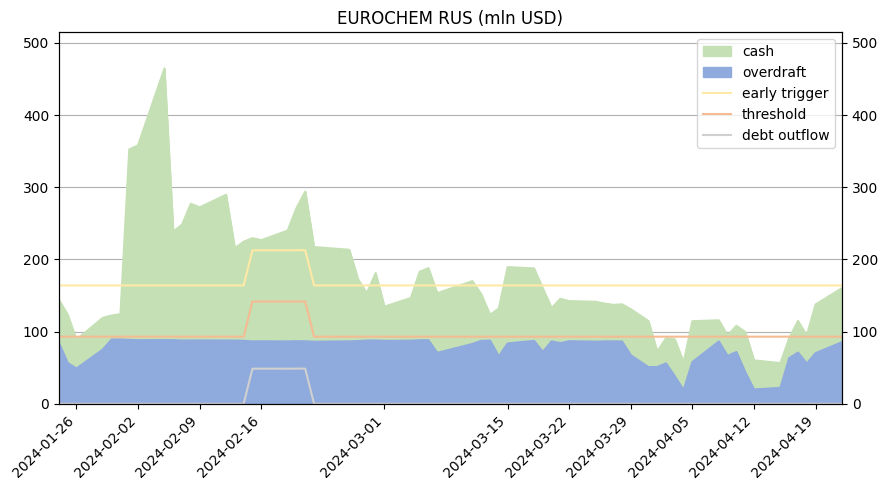

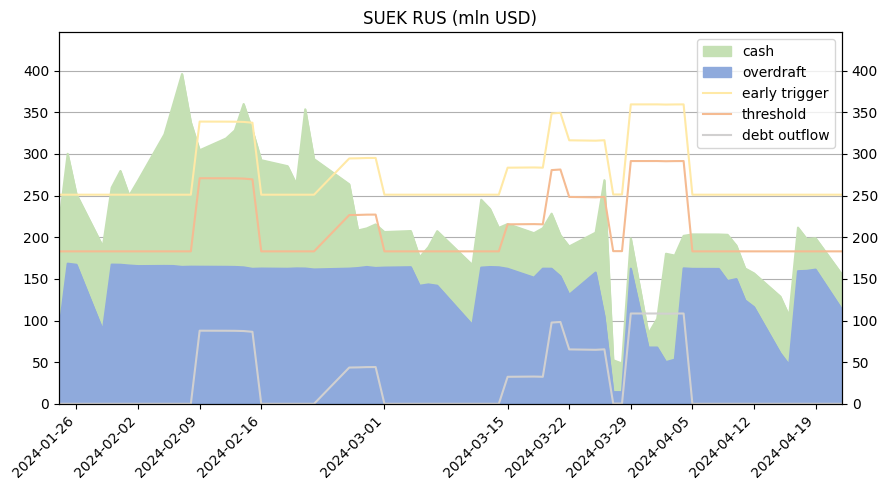

In [118]:
for i in ['EUROCHEM', 'SUEK']:
    data_plot = data_total.query("holding==@i")
    fig, ax = plt.subplots(figsize=(9, 5)) # размер графика
    # Построение фигур и линий
    ax.plot(data_plot.reportDate, data_plot.total, color='#c5e0b4')
    ax.plot(data_plot.reportDate, data_plot.available_ovedraft, color='#8faadc')
    ax.fill_between(data_plot.reportDate, data_plot.total, color='#c5e0b4', label='cash')
    ax.fill_between(data_plot.reportDate, data_plot.available_ovedraft, color='#8faadc', label='overdraft')
    ax.plot(data_plot.reportDate, data_plot.early_trigger_debt, color='#ffe9a6', label='early trigger')
    ax.plot(data_plot.reportDate, data_plot.threshold_debt, color='#f5bb92', label='threshold')
    ax.plot(data_plot.reportDate, data_plot.debt_abs, color='#D1D0D0', label='debt outflow')
    ax.legend(loc='upper right')
    # сетка
    ax.grid(axis='y') 
    ax.set_axisbelow(True)
    # растянуть график по x
    xmin, xmax = data_plot.reportDate.min(), data_plot.reportDate.max() 
    ax.set_xlim([xmin, xmax])
    # растянуть график по y
    ymin, ymax = data_plot.debt_abs.min(), data_plot.total.max() + 50
    ax.set_ylim([ymin, ymax]) 
    ax.twinx().set_ylim(ymin, ymax) # добавить вторую ось y
    # Каждая n-ый день недели в качестве делелния на оси 
    xticks = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].sort_values().tolist()
    plt.xticks(xticks, rotation=45, ha="right")
    xticks_labels = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].astype(str).sort_values().tolist()
    ax.set_xticklabels( xticks_labels, rotation=45, ha="right" )
    plt.title(f'{i} RUS (mln USD)') # название графика
    
    plt.tight_layout()
    plt.savefig(f'{i}.png')


Запись в файл:

In [119]:
TD = data_total.reportDate.max()
TD_str = str(TD)[:10]
Output_file_SUEK = TD_str + '_Oper_liquidity_SUEK.xlsx'
Output_file_ECH = TD_str + '_Oper_liquidity_EUROCHEM.xlsx'

if Print_to_excel == True:
  for i in ['EUROCHEM', 'SUEK']:
      data_print = data_total.query("holding==@i")[['reportDate', 'cash', 'available_ovedraft', 'total', 'debt_outflow','early_trigger', 'threshold']]
      Output_file = TD_str + '_Oper_liquidity_' + i + '.xlsx'
      data_print.to_excel(Output_file, index=False)
      # Create a new or open existing Excel file with openpyxl
      wb = openpyxl.load_workbook(Output_file)  # Open existing or create new
      ws = wb.active
      # Error handling: Check if image file exists
      try:
        img = Image(f'{i}.png')
      except FileNotFoundError:
        print("Error: Image file 'EUROCHEM.png' not found. Skipping image insertion.")
        img = None  # Set img to None to avoid potential errors
      # Insert image if it exists
      if img:
        img.anchor = 'H37'  # Adjust cell reference as needed
        ws.add_image(img)
      # Save the Excel file (overwrite if existing)
      wb.save(Output_file)

In [120]:
data_total.head(2)

,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week,concat_columns,debt_outflow,debt_abs,threshold_debt,early_trigger_debt
0,2024-01-24,EUROCHEM,59.564008,5.159943e+08,8000000000,7.484006e+09,RUB,0.011259,84.265203,143.829212,164,93,2,2024-01-24_EUROCHEM,0.0,0.0,93.0,164.0
1,2024-01-25,EUROCHEM,66.911572,2.965587e+09,8000000000,5.034413e+09,RUB,0.011216,56.467899,123.379471,164,93,3,2024-01-25_EUROCHEM,0.0,0.0,93.0,164.0


Quality_ckeck.Missing_records

In [121]:
query = """
SELECT *
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= trunc(sysdate - interval '30' day)
ORDER BY "reportDate"
"""

data_QC_cash = export_from_RISKCUSTOM(query)
data_QC_cash.tail(3)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,bankName,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate
79525,35811132@WHPROD,N,2024-04-23 18:00:19,WHFLEX,2024-04-22,EUROCHEM,RUBMU,(0) RU,RU,"ООО ""ЕвроХим-БМУ""",Rosbank,RSBNRU,RU,(0) RU,USD,40702840251390000025,active,0.00,0.000000,2022-12-16
79526,35811132@WHPROD,N,2024-04-23 18:00:19,WHFLEX,2024-04-22,EUROCHEM,RUBMU,(0) RU,RU,"ООО ""ЕвроХим-БМУ""",Rosbank,RSBNRU,RU,(0) RU,USD,40702840651390000007,active,0.00,0.000000,2022-12-16
79527,35811132@WHPROD,N,2024-04-23 18:00:19,WHFLEX,2024-04-22,EUROCHEM,RUBMU,(0) RU,RU,"ООО ""ЕвроХим-БМУ""",Sberbank,SABRRU,RU,(0) RU,RUB,40702810230300101165,active,10199.36,109.153058,2024-04-13


In [122]:
data_QC_cash['missing_record'] = data_QC_cash[['buCode', 'bankId', 'accountCurrency', 'accountNumber']].astype(str).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

last_date = data_QC_cash.reportDate.unique()[-1]
pre_last_date = data_QC_cash.reportDate.unique()[-2]
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate == pre_last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

missing_records = [i for i in data_QC_cash_pre_last_date if i not in data_QC_cash_last_date]

data_missing_records = data_QC_cash[(data_QC_cash.missing_record.isin(missing_records)) & (data_QC_cash.reportDate == pre_last_date)]
data_missing_records.head(2)

,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,...,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate,missing_record
72617,35773486@WHPROD,N,2024-04-22 17:45:18,WHFLEX,2024-04-19,SUEK,7B00,(7) AE,AE,Black Sand Commodities,...,CBDUAE,AE,(7) AE,CNY,08614024,active,0.00,0.0000,2024-03-08,7B00_CBDUAE_CNY_08614024
72620,35773486@WHPROD,N,2024-04-22 17:45:18,WHFLEX,2024-04-19,SUEK,7B00,(7) AE,AE,Black Sand Commodities,...,CZCBCN,CN,(5) CN,CNY,6380120105900000190066,active,60607.58,8485.0612,2024-02-29,7B00_CZCBCN_CNY_6380120105900000190066


Quality_ckeck.New_records

In [123]:
new_records = [i for i in data_QC_cash_last_date if i not in data_QC_cash_pre_last_date]

data_new_records = data_QC_cash[(data_QC_cash.missing_record.isin(new_records)) & (data_QC_cash.reportDate == last_date)]
data_new_records.head(2)

,##batch_id,##deleted,##inserted,##origin_name,reportDate,holding,buCode,buCountryGroup,buCountryCode,buName,...,bankId,bankCountryCode,bankCountryGroup,accountCurrency,accountNumber,accountStatus,balance,balanceUsd,statementDate,missing_record
75952,35811132@WHPROD,N,2024-04-23 18:00:19,WHFLEX,2024-04-22,SUEK,1X00,(0) RU,RU,"ООО ""КБС-ЛОГИСТИК""",...,BADJRU,RU,(0) RU,CNY,40702156400000010363,active,0.0,0.0,2024-04-16,1X00_BADJRU_CNY_40702156400000010363
75953,35811132@WHPROD,N,2024-04-23 18:00:19,WHFLEX,2024-04-22,SUEK,1X00,(0) RU,RU,"ООО ""КБС-ЛОГИСТИК""",...,BADJRU,RU,(0) RU,CNY,40702156700001010363,active,0.0,0.0,2024-04-16,1X00_BADJRU_CNY_40702156700001010363


Quality_ckeck.Mapping

In [124]:
data_QC_cash['Map_holding'] = merge_SalesUnits(data_QC_cash, col='buCode', merge_col='holding')
data_QC_cash['Map_holding_2'] = merge_SalesUnits(data_QC_cash, col='buCode', id_col='oebs12ShortCode', merge_col='holding')
data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding_2'] = data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding']
data_map_holding = data_QC_cash.loc[(data_QC_cash.Map_holding_2 != data_QC_cash.holding) & (data_QC_cash.reportDate == data_QC_cash.reportDate.max()), ['buCode', 'holding', 'Map_holding_2']].drop_duplicates()
data_map_holding

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,buCode,holding,Map_holding_2


Запись QC в файл:

In [125]:
str(last_date)[:10]
Output_file = str(last_date)[:10] + '_Oper_liquidity_QC.xlsx'

if Print_qualuty_check == True :
    data_missing_records.to_excel(Output_file, sheet_name='Пропавшие_счета')
    new_list(data_new_records, Output_file, sheet_name='Новые_счета', index=True)
    new_list(data_map_holding, Output_file, sheet_name='Поиск_в_SalesUnits')

Создание письма:

In [126]:

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

for i in ['EUROCHEM', 'SUEK']:
    mailItem = olApp.CreateItem(0)
    mailItem.BodyFormat = 3

    mailItem.Subject = f'Operational liquidity {i} RUS {TD_str}' # mail head
    # mail body
    html_body = f"""<html><body><p>Dear colleagues,<br><br>
    Please find attached daily operational liquidity report as of {TD_str}<br>
    <img src="{(os.path.join(os.getcwd(), i))}.png"><br>
    Below early trigger – to analyze if there is an issue with revenue collection and if there is a risk of threshold violation<br>
    Below threshold – an action plan to return above the threshold<br><br>
    Best regards,<br>
    Maksim Tarakanov<br><br>
    Whatsapp: +7 915 161 29 12<br>
    Financial risk management</p></body></html>"""
    mailItem.To = mail_to # mail to
    mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
        # mail attachment
    if i == 'SUEK':
        mail_attachment = Output_file_SUEK 
    if i == 'EUROCHEM':
        mail_attachment = Output_file_ECH 

    mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
    mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
    mailItem.HTMLBody = html_body
    mailItem.Sensitivity  = 2

    # mailItem.Save()
    mailItem.Display()
    if Send_mail == True:
        mailItem.Send()

In [127]:
mailItem = olApp.CreateItem(0)
mailItem.BodyFormat = 3

mailItem.Subject = f'QC for operational liquidity {TD_str}' # mail head
# mail body
html_body = f"""<html><body><p>Dear colleagues,<br><br>
Please find attached quality control of daily operational liquidity report as of {TD_str}:<br><br>
&nbsp;&nbsp; Missed records - {'<span style="color: green;">OK</span>' if data_missing_records.empty else '<span style="color: red;">Alert</span>'}<br>
&nbsp;&nbsp; New records - {'<span style="color: green;">OK</span>' if data_new_records.empty else '<span style="color: red;">Alert</span>'}<br>
&nbsp;&nbsp; Finding in SalesUnits - {'<span style="color: green;">OK</span>' if data_map_holding.empty else '<span style="color: red;">Alert</span>'}<br><br>
Best regards,<br>
Maksim Tarakanov<br><br>
Whatsapp: +7 915 161 29 12<br>
Financial risk management</p></body></html>"""
mailItem.To = mail_to # mail to
mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
# mail attachment
mail_attachment = Output_file 


mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
mailItem.HTMLBody = html_body
mailItem.Sensitivity  = 2

# mailItem.Save()
mailItem.Display()
if Send_QC_mail == True:
    mailItem.Send()

In [128]:
print('The "Liquidity" was finished')

The "Liquidity" was finished
